In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
!pip install keras-tuner

In [177]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

In [178]:
def create_dataset(dataset, look_back=7):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 7
future_dates = pd.date_range(start='2024-11-05', periods=3, freq='D')

In [179]:
def build_model(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)

    model.add(LSTM(hp_units, input_shape=(look_back, 1),
                   dropout=hp_dropout, recurrent_dropout=hp_dropout))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mape'])

    return model

In [180]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Harris 모델링 및 예측

In [127]:
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_harris.json', 'r') as f:
    harris_data = json.load(f)
harris_df = pd.DataFrame(list(harris_data.items()), columns=['date', 'score'])
harris_df['date'] = pd.to_datetime(harris_df['date'])
harris_df.set_index('date', inplace=True)
harris_df.sort_index(inplace=True)

In [128]:
harris_values = harris_df[['score']].values
scaler_h = MinMaxScaler((0,1))
scaled_h = scaler_h.fit_transform(harris_values)

In [161]:
X_h, y_h = create_dataset(scaled_h, look_back)
train_size_h = int(len(X_h)*0.9)
X_h_train, X_h_val = X_h[:train_size_h], X_h[train_size_h:]
y_h_train, y_h_val = y_h[:train_size_h], y_h[train_size_h:]
X_h_train = X_h_train.reshape((X_h_train.shape[0], X_h_train.shape[1], 1))
X_h_val = X_h_val.reshape((X_h_val.shape[0], X_h_val.shape[1], 1))

In [162]:
tuner_harris = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='harris_tuning_single_LSTM'
)

Reloading Tuner from my_dir/harris_tuning_single_LSTM/tuner0.json


In [163]:
tuner_harris.search(X_h_train, y_h_train,
                    validation_data=(X_h_val, y_h_val),
                    callbacks=[early_stop],
                    verbose=1)

In [164]:
best_hps_h = tuner_harris.get_best_hyperparameters(num_trials=1)[0]
model_harris = tuner_harris.hypermodel.build(best_hps_h)

model_checkpoint_h = ModelCheckpoint('best_model_harris.keras', monitor='val_loss', save_best_only=True)

history_h = model_harris.fit(X_h_train, y_h_train,
                             validation_data=(X_h_val, y_h_val),
                             epochs=50,
                             batch_size=16,
                             callbacks=[early_stop, model_checkpoint_h],
                             verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.2480 - mape: 115410.7734 - val_loss: 0.2423 - val_mape: 79.0100
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1257 - mape: 2964951.7500 - val_loss: 0.0922 - val_mape: 45.6392
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0564 - mape: 2761368.2500 - val_loss: 0.0152 - val_mape: 15.7989
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0497 - mape: 3307539.7500 - val_loss: 0.0104 - val_mape: 14.3282
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0463 - mape: 4701025.5000 - val_loss: 0.0177 - val_mape: 17.5822


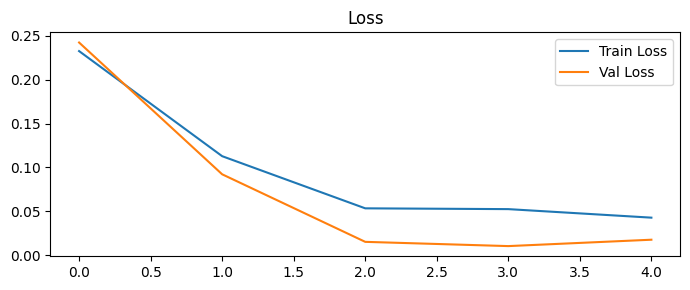

[0.2325085550546646, 0.11280999332666397, 0.05340513959527016, 0.052500031888484955, 0.04278825223445892]


In [165]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_h.history['loss'], label='Train Loss')
ax.plot(history_h.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_h.history['loss'])

In [166]:
best_model_harris = tf.keras.models.load_model('best_model_harris.keras')

In [167]:
# Harris 예측
last_sequence_h = scaled_h[-look_back:]
current_input_h = last_sequence_h.reshape((1, look_back, 1))
predictions_h = []
for i in range(3):
    pred_h = best_model_harris.predict(current_input_h, verbose=0)
    predictions_h.append(pred_h[0,0])
    current_input_h = np.append(current_input_h[:,1:,:], [[[pred_h[0,0]]]], axis=1)

In [168]:
predictions_h = scaler_h.inverse_transform(np.array(predictions_h).reshape(-1,1))
prediction_df_harris = pd.DataFrame(predictions_h, index=future_dates, columns=['predicted_score'])

## Trump 모델링 및 예측

In [103]:
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_trump.json', 'r') as f:
    trump_data = json.load(f)
trump_df = pd.DataFrame(list(trump_data.items()), columns=['date', 'score'])
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df.set_index('date', inplace=True)
trump_df.sort_index(inplace=True)

In [104]:
trump_values = trump_df[['score']].values
scaler_t = MinMaxScaler((0,1))
scaled_t = scaler_t.fit_transform(trump_values)

In [151]:
X_t, y_t = create_dataset(scaled_t, look_back)
train_size_t = int(len(X_t)*0.80)
X_t_train, X_t_val = X_t[:train_size_t], X_t[train_size_t:]
y_t_train, y_t_val = y_t[:train_size_t], y_t[train_size_t:]
X_t_train = X_t_train.reshape((X_t_train.shape[0], X_t_train.shape[1], 1))
X_t_val = X_t_val.reshape((X_t_val.shape[0], X_t_val.shape[1], 1))

In [152]:
tuner_trump = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='trump_tuning_single_LSTM'
)

Reloading Tuner from my_dir/trump_tuning_single_LSTM/tuner0.json


In [153]:
tuner_trump.search(X_t_train, y_t_train,
                   validation_data=(X_t_val, y_t_val),
                   callbacks=[early_stop],
                   verbose=1)

In [154]:
best_hps_t = tuner_trump.get_best_hyperparameters(num_trials=1)[0]
model_trump = tuner_trump.hypermodel.build(best_hps_t)

model_checkpoint_t = ModelCheckpoint('best_model_trump.keras', monitor='val_loss', save_best_only=True)

history_t = model_trump.fit(X_t_train, y_t_train,
                            validation_data=(X_t_val, y_t_val),
                            epochs=50,
                            batch_size=16,
                            callbacks=[early_stop, model_checkpoint_t],
                            verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2451 - mape: 420844.6250 - val_loss: 0.1637 - val_mape: 71.9251
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0933 - mape: 3122758.5000 - val_loss: 0.0553 - val_mape: 63.3202
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0385 - mape: 7273677.0000 - val_loss: 0.0512 - val_mape: 81.3290
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0466 - mape: 11338492.0000 - val_loss: 0.0409 - val_mape: 70.3268
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0345 - mape: 5597498.0000 - val_loss: 0.0464 - val_mape: 62.6352


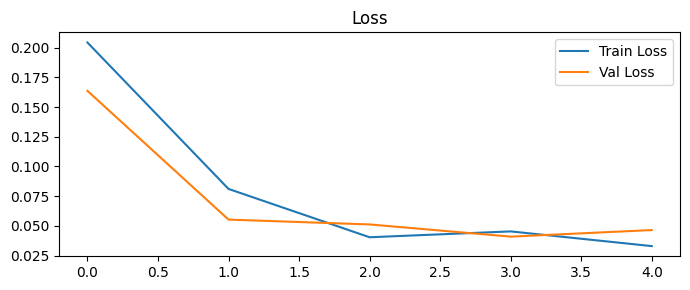

[0.20443740487098694, 0.08108676970005035, 0.04037820175290108, 0.045314304530620575, 0.032932233065366745]


In [155]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_t.history['loss'], label='Train Loss')
ax.plot(history_t.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_t.history['loss'])

In [142]:
best_model_trump = tf.keras.models.load_model('best_model_trump.keras')

In [143]:
# Trump 예측
last_sequence_t = scaled_t[-look_back:]
current_input_t = last_sequence_t.reshape((1, look_back, 1))
predictions_t = []
for i in range(3):
    pred_t = best_model_trump.predict(current_input_t, verbose=0)
    predictions_t.append(pred_t[0,0])
    current_input_t = np.append(current_input_t[:,1:,:], [[[pred_t[0,0]]]], axis=1)

In [144]:
predictions_t = scaler_t.inverse_transform(np.array(predictions_t).reshape(-1,1))
prediction_df_trump = pd.DataFrame(predictions_t, index=future_dates, columns=['predicted_score'])

## 시각화

In [145]:
print(harris_df)
print(prediction_df_harris)

               score
date                
2024-07-25  0.353315
2024-07-26  0.338160
2024-07-27  0.293853
2024-07-28  0.224996
2024-07-29  0.234419
...              ...
2024-10-31  0.250618
2024-11-01  0.329888
2024-11-02  0.308602
2024-11-03  0.252376
2024-11-04  0.272945

[103 rows x 1 columns]
            predicted_score
2024-11-05         0.287740
2024-11-06         0.302613
2024-11-07         0.301271


In [146]:
print(trump_df.index)
print(prediction_df_trump)

DatetimeIndex(['2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30',
               ...
               '2024-10-26', '2024-10-27', '2024-10-28', '2024-10-29',
               '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-02',
               '2024-11-03', '2024-11-04'],
              dtype='datetime64[ns]', name='date', length=107, freq=None)
            predicted_score
2024-11-05         0.305213
2024-11-06         0.340664
2024-11-07         0.352648


In [147]:
# 과거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기
harris_11_05 = pd.DataFrame({'score': [prediction_df_harris.loc['2024-11-05', 'predicted_score']]},
                             index=pd.to_datetime(['2024-11-05']))
trump_11_05 = pd.DataFrame({'score': [prediction_df_trump.loc['2024-11-05', 'predicted_score']]},
                            index=pd.to_datetime(['2024-11-05']))

harris_df_extended = pd.concat([harris_df, harris_11_05, prediction_df_harris], axis=0)
trump_df_extended = pd.concat([trump_df, trump_11_05, prediction_df_trump], axis=0)

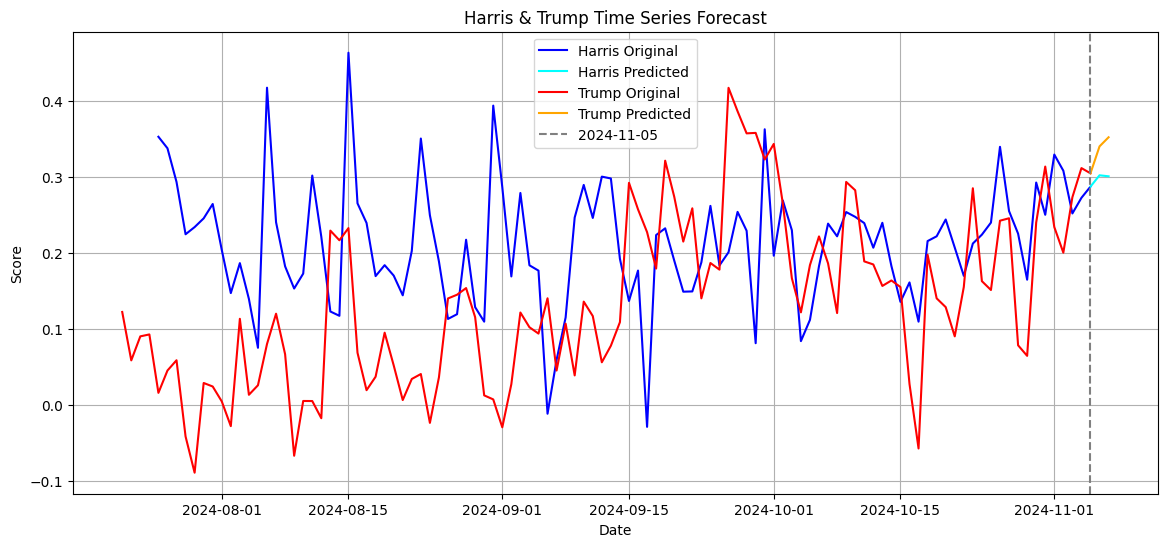

In [148]:
# Plot the extended data
plt.figure(figsize=(14, 6))

# Plot for Harris
plt.plot(harris_df_extended.index, harris_df_extended['score'], label='Harris Original', color='blue')
plt.plot(prediction_df_harris.index, prediction_df_harris['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump
plt.plot(trump_df_extended.index, trump_df_extended['score'], label='Trump Original', color='red')
plt.plot(prediction_df_trump.index, prediction_df_trump['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [149]:
# Filter the data for the specific date range (2024-11-02 to 2024-11-07)
date_range = pd.date_range(start='2024-11-02', end='2024-11-05')
pred_date_range = pd.date_range(start='2024-11-05', end='2024-11-07')

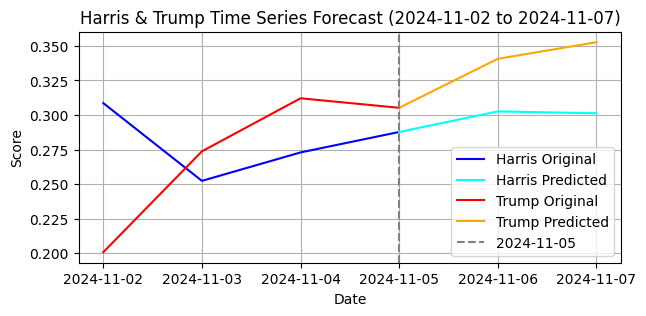

In [150]:
# Plot the extended data for the specified date range
plt.figure(figsize=(7, 3))

# Plot for Harris within the date range
harris_range = harris_df_extended.loc[date_range]
plt.plot(harris_range.index, harris_range['score'], label='Harris Original', color='blue')
harris_pred_range = prediction_df_harris.loc[pred_date_range]
plt.plot(harris_pred_range.index, harris_pred_range['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump within the date range
trump_range = trump_df_extended.loc[date_range]
plt.plot(trump_range.index, trump_range['score'], label='Trump Original', color='red')
trump_pred_range = prediction_df_trump.loc[pred_date_range]
plt.plot(trump_pred_range.index, trump_pred_range['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast (2024-11-02 to 2024-11-07)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()